In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import numpy as np

In [2]:
# load data
data = pd.read_csv("./data/BTC-USD-1d.csv")

# data preprocessing

data['RSI'] = ta.rsi(data.Close, length=15)
data['EMAF'] = ta.ema(data.Close, length=20)
data['EMAM'] = ta.ema(data.Close, length=100)
data['EMAS'] = ta.ema(data.Close, length=150)

data['Target'] = data['Adj Close'] - data['Open']
data['Target'] = data['Target'].shift(-1)
data['TargetNextClose'] = data['Adj Close'].shift(-1)

# TODO clean
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)
dataset = data.iloc[:, 0:11]

# data scaling 
min_vals = dataset.min()
max_vals = dataset.max()
dataset = (dataset - min_vals) / (max_vals - min_vals)

# TODO feature engineering
backcandles = 30
X = []
for j in range(8):
    X.append([])
    for i in range(backcandles, len(dataset)):
        X[j].append(dataset.iloc[i - backcandles:i, j].values)  # Use .values to convert to numpy array

X = np.moveaxis(X, [0], [2])
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(dataset.iloc[backcandles:, -1].values, dtype=torch.float32).reshape(-1, 1)

# split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [3]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [4]:
# parameters
input_size = X.shape[2]
hidden_size = 256
num_layers = 2
num_epochs = 50
batch_size = 15
learning_rate = 0.0005

In [5]:
model = LSTMModel(input_size, hidden_size, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [6]:
# train
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.0027
Epoch [20/50], Loss: 0.0014
Epoch [30/50], Loss: 0.0007
Epoch [40/50], Loss: 0.0005
Epoch [50/50], Loss: 0.0003


In [7]:
# eval
model.eval()
with torch.no_grad():
    y_pred = model(X_test)


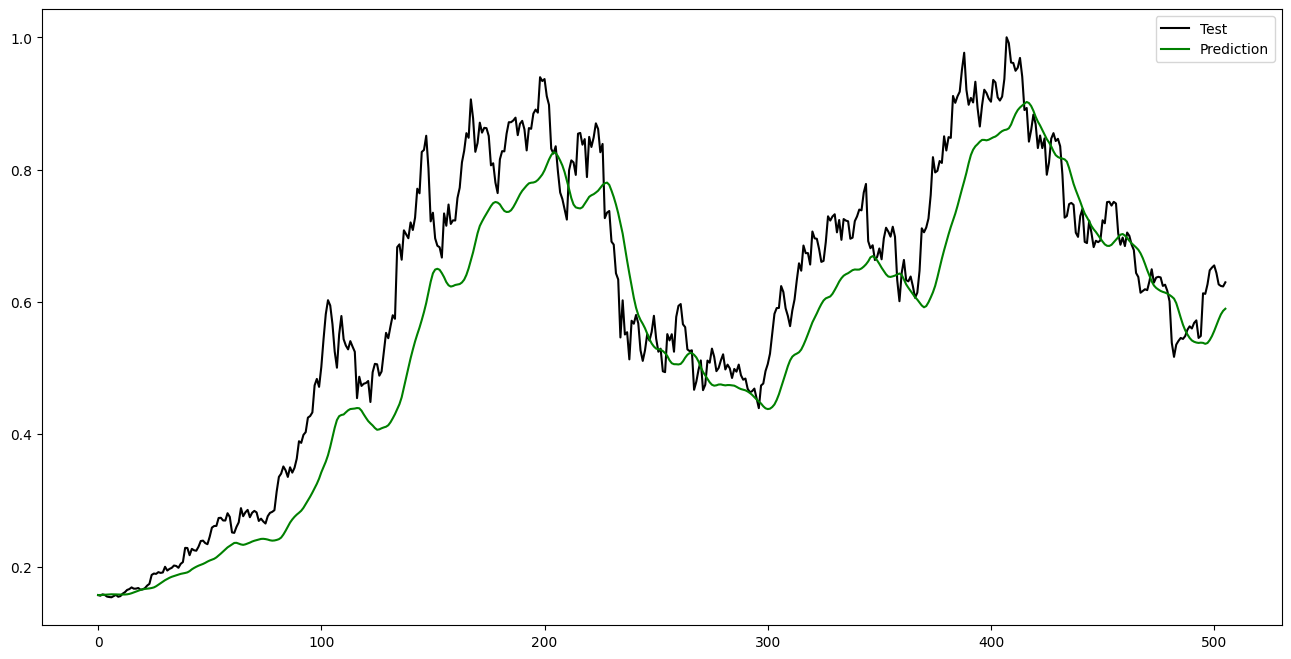

In [8]:
# plot
plt.figure(figsize=(16, 8))
plt.plot(y_test.numpy(), color='black', label='Test')
plt.plot(y_pred.numpy(), color='green', label='Prediction')
plt.legend()
plt.show()